In [1]:
using DataFrames
using CSV
using StatsPlots

In [2]:
withdraw_transactions_df = CSV.read("../data/tornado_withdraw_df.csv", DataFrame)
deposit_transactions_df = CSV.read("../data/deposit_transactions.csv", DataFrame)

ENV["COLUMNS"]=10000
ENV["LINES"]=10;

In [3]:
first(withdraw_transactions_df, 2)

,Column1,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,input,receipt_cumulative_gas_used,receipt_gas_used,receipt_contract_address,receipt_root,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price,recipient_address
,Int64,String,Int64,Int64,String,String,Int64,Int64,Int64,String,Int64,Int64,Missing,Missing,Int64,String,Int64,String,Missing,Missing,Missing,Int64,String
1,0,0x8211d6815cdd607a1f8a0d5db08b3cd0121d6df4c6f5b52023788883e6fe7a97,0,54,0x00058bf70d45aa62a493e5fc596974edde903324,0x910cbd523d972eb0a6f4cae4618ad62622b39dbf,0,421760,37000000000,0x21a0adb600000000000000000000000000000000000000000000000000000000000000e0262c5b75219fb59b3a6e535d04d7f4ddf7b8ffd3236263babebaf0e352717db22782f28dda1bfccf8b1c59d0595a400214a32bdad8dcd3b1753a4013a8d6555300000000000000000000000000058bf70d45aa62a493e5fc596974edde90332400000000000000000000000000058bf70d45aa62a493e5fc596974edde9033240000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000055def7d206642ea94235420978ff0ea81fd15e7d8d7f9ab2b261bf980bb1d321e78994d9d0c49408a22a7481681f7945d8be26efc23e183a412169da7af4422fb173319129d37b7db5df1dbb9f6f5db60f1e5f81ab07f4f030dac1ce83999e2cba949a94b22d1f4af9749f46306db16ea555cea7412951222f7fc5716eae5d0a358bd5d1527136137ec436cb67149a2ca998342359f4f2bc8904d1ae5b520522b4b6dbcdfec5217e30fcd60797cf601bd77b3b0e9157e2e2331408b2553a340e4c89700723498c6e30c1ca67a9a5d0e64a3013845f26299969e7c824aacf6e22ac16d06453342296443d0c7a37bea887ff98cb0888481525a0cbc761754d9d,2727540,321760,missing,missing,1,2020-07-16 04:21:43 UTC,10468347,0x97002c5d89010843864301297092eb60b3d902f1850d863717db7ec768e7896e,missing,missing,missing,37000000000,0x00058BF70d45AA62A493E5FC596974EdDe903324
2,1,0xcc8746c16a2bf379e8319b7c190676b77508f09f7a9cec13dd5f77514f446034,800,56,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,0,423207,13000000000,0x21a0adb600000000000000000000000000000000000000000000000000000000000000e00a52cba850f4ad215648a969675fe4f4b02d6ddae38a189e81396e742962928527e852fdad1aed9326a692b63973cf72c5d6b4a13a6c54599780e870a7c304c80000000000000000000000000039f22efb07a647557c7c5d17854cfd6d489ef30000000000000000000000000039f22efb07a647557c7c5d17854cfd6d489ef300000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010022b904e7729cc7af2d50170a9b57934740815876a1f96a43c832ece57ce95dae2d98b39685cb87a18d38e29c20271506d7103bc391b490a7d524c76c91ff4f9518442626bafb9d4d95c507fa0d3b4a19f34c457bb22dab65432c7c1cd90742200323a69be5b17c37f876c8c212625f955e69151f9b5f695899743a9798f11959226c0dfbd8cf0db70ac928850726479a0a741e0b26ad81fe1d4415d22ce258732c1a9adf37aa06373fea66b14dad706bd08c951d497b3ef8ca5c550f942cc726140dbbb541564c78a4daa44bd5ec69b192b8acf8df2ed2d86386b17abfbf991d1405c2269265226205195dd90d96119383d494b261c31e19b7b6de46ffcf9c1b,3032779,323207,missing,missing,1,2019-12-16 20:06:53 UTC,9117186,0x8dc6ade4626b61074d088ba600ddcc2686bdc1795681440ce9a86cc6dbdc4dac,missing,missing,missing,13000000000,0x0039F22efB07A647557C7C5d17854CFD6D489eF3


In [4]:
function get_number_of_withdraws(withdraw_transaction, withdraw_transactions_df)
    n_withdraws = 1
    for row ∈ eachrow(withdraw_transactions_df)
        if (row.recipient_address == withdraw_transaction.recipient_address) && (row.block_timestamp <= withdraw_transaction.block_timestamp)&& (row.hash != withdraw_transaction.hash)
            n_withdraws += 1
        end
    end
    return n_withdraws
end

get_number_of_withdraws (generic function with 1 method)

In [5]:
function get_same_number_of_deposits(n_withdraws, deposit_transactions_df)
    deposits_with_same_number = combine(groupby(deposit_transactions_df, :from_address), nrow => :count)
    return filter(row -> row.count == n_withdraws, deposits_with_same_number)[!, :from_address]
end

get_same_number_of_deposits (generic function with 1 method)

In [6]:
function same_number_of_deposits_heuristic(withdraw_transaction, deposit_transactions_df, withdraw_transactions_df)
    n_withdraws = get_number_of_withdraws(withdraw_transaction, withdraw_transactions_df)
    
    Ϛ = get_same_number_of_deposits(n_withdraws, deposit_transactions_df)
    
    P = 1 - 1/length(Ϛ)
    
    return isinf(P) ? 1 : P
end

same_number_of_deposits_heuristic (generic function with 1 method)

In [7]:
withdraw_transaction = withdraw_transactions_df[105,:]

,Column1,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,input,receipt_cumulative_gas_used,receipt_gas_used,receipt_contract_address,receipt_root,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price,recipient_address
,Int64,String,Int64,Int64,String,String,Int64,Int64,Int64,String,Int64,Int64,Missing,Missing,Int64,String,Int64,String,Missing,Missing,Missing,Int64,String
105,104,0x48fb561bdbb96981906e5b4237fa4cd3444dad571ed6521e788d75407923304e,990,110,0x0360b232285a801cbae01c984fb680ba2f465fdc,0x910cbd523d972eb0a6f4cae4618ad62622b39dbf,0,404364,65000000000,0x21a0adb600000000000000000000000000000000000000000000000000000000000000e004b30701b5455e987227e6c62efe53344deaa1cd3576f893dab411127910af7a0337da8784d25dc9e5aa2fca81d4202eb1922f1776c644f539fe9bcffa6127070000000000000000000000005b6d9100ce41bacc39c3d2629098393f9d386c7b0000000000000000000000000360b232285a801cbae01c984fb680ba2f465fdc000000000000000000000000000000000000000000000000008e1bc9bf04000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100127bc83dce01d23f1c1f6faad76094b8badd7e44f7b19ac131eb2f83e6727445210951262375fa07fa6aa59ee567d6c0e02c0a2a09cd67bb45da03e10aee92782f78ce350f911fe5f830856195a6ef78f1cb4a4217d1de0214a2c8cfc9929b411c5674155cd50e7a44c09856ebe36689a98cc6efad92ccd83adc98210947557b05db34f1c917da47e2f19ac3af8fdfb4d91104f6f65b6570520005495d6eb1e9256c0cbadc2a6dbe3ceb557646e594d0ede3d5c40638473931a5718d5902ef642b9cf4d649a929461a0390ba06dfddae5ac302c2685a78278162e0ef0a94fcd8218f8269bff211f94163cc7a2ecf2af1973bfdc5dbaf5540e5f6b383b184af4c,7521693,354364,missing,missing,1,2020-10-05 06:05:03 UTC,10994012,0x48984cd5e2f35dd13d1ffe07d3e62b50c59c1aa52cd603794f215de7382d34e4,missing,missing,missing,65000000000,0x5B6D9100CE41BaCC39C3D2629098393F9d386C7B


In [8]:
get_same_number_of_deposits(34, deposit_transactions_df)

3-element Vector{String}:
 "0xbcb7ca4ceed6730cf3d7673fd2218defbcccef6d"
 "0x545f670fd45141383cfc0710ff7e1f9b38c8fb19"
 "0x00a4006ea66c4e0f92d45d55a9ef5fd58f31d3c7"

In [9]:
same_number_of_deposits_heuristic(withdraw_transaction, deposit_transactions_df, withdraw_transactions_df)

0.9997754827121689

In [10]:
function apply_same_number_of_deposits_heuristic(deposit_transactions_df, withdraw_transactions_df)
    tx_hash_and_anonimity_score = Dict()
    for withdraw_row ∈ eachrow(withdraw_transactions_df)
        anonimity_score = same_number_of_deposits_heuristic(withdraw_row, deposit_transactions_df, withdraw_transactions_df)
        tx_hash_and_anonimity_score[withdraw_row.hash] = anonimity_score
    end
    tx_hash_and_anonimity_score
end

apply_same_number_of_deposits_heuristic (generic function with 1 method)

In [11]:
scores = apply_same_number_of_deposits_heuristic(deposit_transactions_df, withdraw_transactions_df)


Dict{Any, Any} with 22009 entries:
  "0xe5bb17e135adbd5c381f626920779db580f4dbb4b2c8ee557df7fc17065f80d7" => 0.999184
  "0x86cbefe25c942108732dd4aded45fa322a777f3a31c6b660343934b2cbb971d6" => 0.998498
  "0xe02d94bb77ec0ebf35b99a3040f7d6da3dcfe3c97c728dfd9ac4d08fdc3a1394" => 0.75
  "0x5f863ded4ac679e4075ef59097067e96182e20ce0479390d0a5613fd10443498" => 0.999184
  "0xbbfc2bec5bb8079f8b9aff36bc18d55d0ed22fd01dccf1b28c16b8cf27351bd2" => 0.999775
  ⋮                                                                    => ⋮

In [12]:
score_values = values(scores) |> collect

22009-element Vector{Any}:
 0.9991843393148451
 0.9984984984984985
 0.75
 ⋮
 0.9984984984984985
 0.9991843393148451

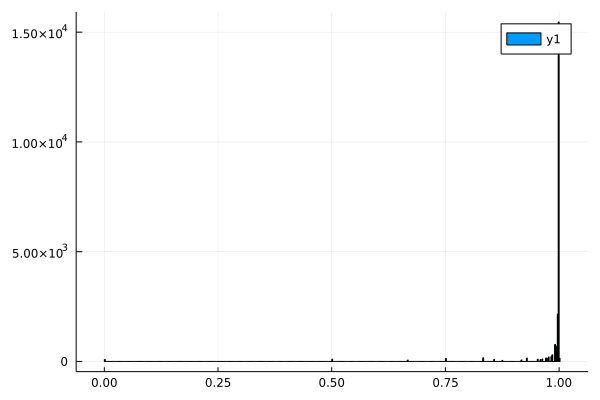

In [14]:
histogram(score_values, bins=500)